#### Load Libraries and Data

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('iteration4').getOrCreate()

In [2]:
df = spark.read.csv('Absenteeism_at_work.csv', sep = ';', inferSchema=True, header = True)

In [ ]:
df.show()

In [ ]:
df.head(5)

#### Data Description/Exploration/Cleaning

In [ ]:
print((df.count(), len(df.columns)))
df.printSchema()

In [ ]:
df.select('Reason for absence', 'Month of absence', 'Day of the week', 
          'Seasons', 'Transportation expense', 'Distance from Residence to Work').describe().show()
df.select('Service time', 'Age', 'Work load Average/day ', 'Hit target',
          'Disciplinary failure', 'Education').describe().show()
df.select('Son', 'Social drinker', 'Social smoker', 'Pet',
          'Body mass index', 'Absenteeism time in hours').describe().show()

In [7]:
data = df.toPandas()

In [ ]:
data['Absenteeism time in hours'].plot.hist()

In [9]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)
corr_matrix = Correlation.corr(df_vector, vector_col)
cm = corr_matrix.collect()[0]['pearson({})'.format(vector_col)].values

24/05/23 20:32:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [ ]:
corr = []
for i in range(len(cm)): 
    if i%21 == 20:
        corr.append(cm[i])
corr

In [ ]:
df.groupby("Reason for absence").count().show()

In [ ]:
df.tail(5)

In [ ]:
from pyspark.sql.functions import avg,stddev
dict = {}
dict1 = {}
for col in df.columns:
    dev = df.select(stddev(col)).collect()[0][0]
    m = df.select(avg(col)).collect()[0][0]
    upper_limit = m + (3*dev)
    lower_limit = m - (3*dev)
    dataframe = df.filter((df[col]<lower_limit) | (df[col]>upper_limit))
    dict[col] = dataframe.count()
    dict1[col] = dataframe
dict

In [ ]:
pet = dict1['Pet']
pet.select(pet['Pet']).show()

In [ ]:
from pyspark.sql.types import (StructField,StringType,IntegerType,BooleanType,DoubleType,StructType)
data_schema = [StructField('ID',StringType(),True),
              StructField('Reason for absence',StringType(),True),
              StructField('Month of absence',StringType(),True),
              StructField('Day of the week',StringType(),True),
              StructField('Seasons',StringType(),True),
              StructField('Transportation expense',IntegerType(),True),
              StructField('Distance from Residence to Work',IntegerType(),True),
              StructField('Service time',IntegerType(),True),
              StructField('Age',IntegerType(),True),
              StructField('Work load Average/day ',DoubleType(),True),
              StructField('Hit target',IntegerType(),True),
              StructField('Disciplinary failure',StringType(),True),
              StructField('Education',StringType(),True),
              StructField('Son',IntegerType(),True),
              StructField('Social drinker',StringType(),True),
              StructField('Social smoker',StringType(),True),
              StructField('Pet',IntegerType(),True),
              StructField('Weight',IntegerType(),True),
              StructField('Height',IntegerType(),True),
              StructField('Body mass index',IntegerType(),True),
              StructField('Absenteeism time in hours',IntegerType(),True)]
final_struct = StructType(fields=data_schema)
df = spark.read.csv('Absenteeism_at_work.csv', sep = ';', schema=final_struct, header = True)
df.printSchema()

In [ ]:
df = spark.read.csv('Absenteeism_at_work.csv', sep = ';', inferSchema=True, header = True)
df = df.drop('Weight', 'Height')
print((df.count(), len(df.columns)))
df.printSchema()

In [ ]:
from pyspark.sql.functions import mode, when
mode = df.select(mode('Month of absence')).collect()[0][0]
df_new = df.withColumn('Month of absence', when(df['Month of absence']=='0', mode).otherwise(df['Month of absence']))
df = df_new
df.tail(3)

In [ ]:
df_new = df.withColumn('Pet', when(df['Pet'] > '0', 1).otherwise(df['Pet']))
df = df_new
df.select(df['Pet']).head(15)

In [ ]:
df.groupby("Pet").count().show()

In [ ]:
mod_df = df.drop('ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Seasons')
mod_df.printSchema()

In [ ]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import udf
bucketizer = Bucketizer(splits=[0, 0.1, 8, 20, float('Inf') ],
                        inputCol="Absenteeism time in hours", outputCol="Absenteeism Range")
df_buck = bucketizer.setHandleInvalid("keep").transform(mod_df)
names = {0.0:"Not Absent", 1.0: "(0, 8]", 2.0:"(8, 20]", 3.0: ">20"}
udf_foo = udf(lambda x: names[x], StringType())
df_buck = df_buck.withColumn("Absenteeism Range String", udf_foo("Absenteeism Range"))
mod_df = df_buck
mod_df.select(mod_df['Absenteeism Range String']).head(15)

In [ ]:
mod_df.groupby("Absenteeism Range String").count().show()

In [ ]:
import pandas as pd
df1 = spark.read.csv('Absenteeism_at_work.csv', sep = ';', inferSchema=True, header = True)
df2 = pd.read_excel('Absenteeism_at_work.xls')
df2 = spark.createDataFrame(df2)
df_concat = df1.union(df2)
df_concat.describe().show()

In [142]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=['ID','Reason for absence','Month of absence','Day of the week','Seasons',
               'Transportation expense','Distance from Residence to Work','Service time',
               'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure',
               'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Body mass index',],
    outputCol="features")
output = assembler.transform(df)

In [143]:
final_data = output.select("features",'Absenteeism time in hours')
final_data.show()

+--------------------+-------------------------+
|            features|Absenteeism time in hours|
+--------------------+-------------------------+
|[11.0,26.0,7.0,3....|                        4|
|[36.0,0.0,7.0,3.0...|                        0|
|[3.0,23.0,7.0,4.0...|                        2|
|[7.0,7.0,7.0,5.0,...|                        4|
|[11.0,23.0,7.0,5....|                        2|
|[3.0,23.0,7.0,6.0...|                        2|
|[10.0,22.0,7.0,6....|                        8|
|[20.0,23.0,7.0,6....|                        4|
|[14.0,19.0,7.0,2....|                       40|
|[1.0,22.0,7.0,2.0...|                        8|
|[20.0,1.0,7.0,2.0...|                        8|
|[20.0,1.0,7.0,3.0...|                        8|
|[20.0,11.0,7.0,4....|                        8|
|[3.0,11.0,7.0,4.0...|                        1|
|[3.0,23.0,7.0,4.0...|                        4|
|[24.0,14.0,7.0,6....|                        8|
|[3.0,23.0,7.0,6.0...|                        2|
|[3.0,21.0,7.0,2.0..

In [ ]:
from pyspark.ml.feature import ChiSqSelector
selector = ChiSqSelector(numTopFeatures=10, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="Absenteeism time in hours")
result = selector.fit(final_data).transform(final_data)
print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

In [145]:
assembler1 = VectorAssembler(
    inputCols=['Transportation expense','Distance from Residence to Work','Service time',
               'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure',
               'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Body mass index'],
    outputCol="features")
output1 = assembler1.transform(mod_df)

In [ ]:
final_data1 = output1.select("features",'Absenteeism Range', 'Absenteeism Range String')
final_data1.show()

In [ ]:
selector1 = ChiSqSelector(numTopFeatures=10, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="Absenteeism Range")
result = selector1.fit(final_data1).transform(final_data1)
print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

In [ ]:
from pyspark.ml.feature import StandardScaler
assembler2 = VectorAssembler(
    inputCols=['ID','Reason for absence','Month of absence','Day of the week','Seasons',
               'Transportation expense','Distance from Residence to Work','Service time',
               'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure',
               'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Body mass index',
               'Absenteeism time in hours'],
    outputCol="features")
output2 = assembler2.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(output2)
scaledData = scalerModel.transform(output2)
scaledData.select(scaledData['scaledFeatures']).show()

In [155]:
vec = "scaledFeatures"
corr_matrix1 = Correlation.corr(scaledData, vec)
cm1 = corr_matrix1.collect()[0]['pearson({})'.format(vec)].values

In [ ]:
cor = []
for i in range(len(cm1)): 
    if i%21 == 20:
        cor.append(cm1[i])
cor

#### Modelling

## Clustering

In [158]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
for K in range(2,11):
    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize = 1)
    BKMeans_fit=BKMeans_.fit(output2)
    BKMeans_transform=BKMeans_fit.transform(output2) 
    evaluation_score=evaluator.evaluate(BKMeans_transform)
    silhouette_scores.append(evaluation_score)

In [159]:
silhouette_scores

[0.5601345373509408,
 0.44917277743330825,
 0.43915730922822616,
 0.38386161393052526,
 0.456503428710966,
 0.4846516543659803,
 0.4917176441237848,
 0.4053011001070508,
 0.3767980997159723]

Text(0, 0.5, 'Silhouette Score')

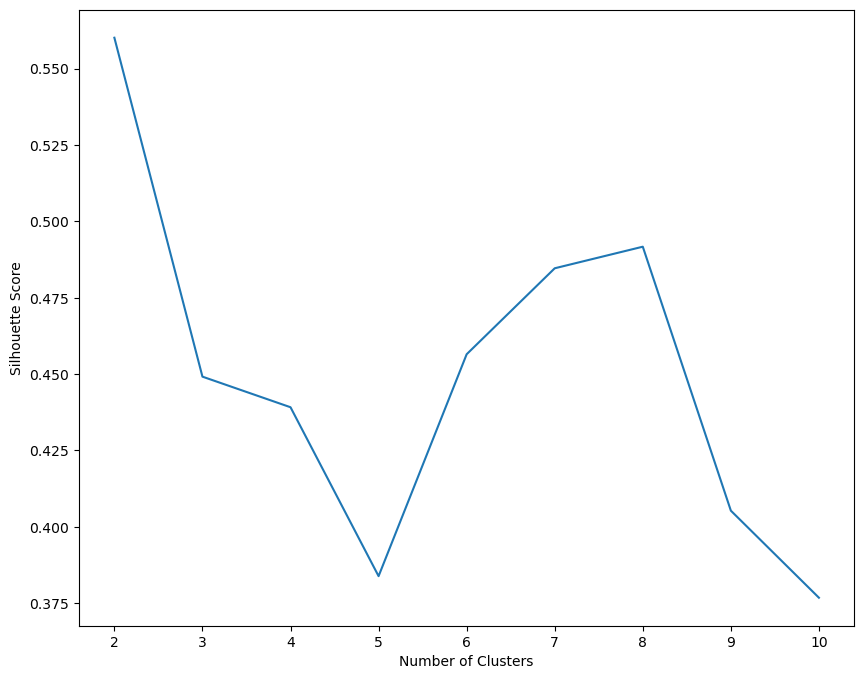

In [160]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [162]:
BKMeans_=BisectingKMeans(featuresCol='features', k=8) 
BKMeans_Model=BKMeans_.fit(output2)
BKMeans_transform=BKMeans_Model.transform(output2)

In [185]:
BKMeans_transform.groupby("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   20|
|         6|   96|
|         3|   66|
|         5|  171|
|         4|   87|
|         7|   63|
|         2|  165|
|         0|   72|
+----------+-----+



In [197]:
cluster1 = BKMeans_transform.filter(BKMeans_transform['prediction'] == 1)
worker = cluster1.groupby("ID").mean().select(['avg(Transportation expense)','avg(Distance from Residence to Work)',
                                      'avg(Service time)','avg(Age)', 'avg(Work load Average/day )', 
                                      'avg(Hit target)', 'avg(Son)', 'avg(Body mass index)',
                                      'avg(Absenteeism time in hours)'])
worker.select(['avg(Transportation expense)','avg(Distance from Residence to Work)',
                                      'avg(Service time)','avg(Age)', 'avg(Work load Average/day )']).show()
worker.select(['avg(Hit target)', 'avg(Son)', 'avg(Body mass index)',
                                      'avg(Absenteeism time in hours)']).show()

+---------------------------+------------------------------------+-----------------+--------+---------------------------+
|avg(Transportation expense)|avg(Distance from Residence to Work)|avg(Service time)|avg(Age)|avg(Work load Average/day )|
+---------------------------+------------------------------------+-----------------+--------+---------------------------+
|                      118.0|                                10.0|             10.0|    37.0|          310.2443846153846|
|                      118.0|                                13.0|             18.0|    50.0|                    351.752|
+---------------------------+------------------------------------+-----------------+--------+---------------------------+

+-----------------+--------+--------------------+------------------------------+
|  avg(Hit target)|avg(Son)|avg(Body mass index)|avg(Absenteeism time in hours)|
+-----------------+--------+--------------------+------------------------------+
|95.38461538461539|     

## DT Regression

In [166]:
from pyspark.ml.regression import DecisionTreeRegressor
train_data,test_data = final_data.randomSplit([0.7,0.3])
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Absenteeism time in hours")
dt_model = dt.fit(train_data)

In [171]:
print("Feature Importances:")
feature_importances = dt_model.featureImportances
for i, imp in enumerate(feature_importances.toArray()):
     print(f"Feature {i+1}: {imp}")
print("Number of Nodes:", dt_model.numNodes)

Feature Importances:
Feature 1: 0.0036755328892827746
Feature 2: 0.5984887241621167
Feature 3: 0.04582862738210971
Feature 4: 0.10236904126859285
Feature 5: 0.0007625943053254186
Feature 6: 0.0009252284488792983
Feature 7: 0.002651819703703617
Feature 8: 0.0
Feature 9: 0.11544278335776
Feature 10: 0.0
Feature 11: 0.0009072084570098673
Feature 12: 0.0
Feature 13: 0.0
Feature 14: 0.0012957793308573167
Feature 15: 0.12488804463411136
Feature 16: 0.0
Feature 17: 0.0
Feature 18: 0.002764616060251
Number of Nodes: 39


In [177]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = dt_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Absenteeism time in hours", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

r2_evaluator = RegressionEvaluator(labelCol="Absenteeism time in hours", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print("R-squared (R²) on test data:", r2)

Root Mean Squared Error (RMSE) on test data: 17.597218384236047
R-squared (R²) on test data: -0.5102049903624368


AttributeError: 'DecisionTreeRegressionModel' object has no attribute 'evaluate'

## RF Classifier

In [168]:
from pyspark.ml.classification import RandomForestClassifier
train_data1,test_data1 = final_data1.randomSplit([0.7,0.3])
rf = RandomForestClassifier(featuresCol="features", labelCol="Absenteeism Range")
rf_model = rf.fit(train_data1)

In [169]:
print("Feature Importances:")
feature_importances = rf_model.featureImportances
for i, imp in enumerate(feature_importances.toArray()):
   print(f"Feature {i+1}: {imp}")
print("Number of Trees:", rf_model.getNumTrees)
print("Total Number of Nodes:", rf_model.totalNumNodes)

Feature Importances:
Feature 1: 0.18219175317741965
Feature 2: 0.04791049553312474
Feature 3: 0.09279485030229565
Feature 4: 0.07373920613670912
Feature 5: 0.05433807710891458
Feature 6: 0.03971414824393991
Feature 7: 0.3763860935539912
Feature 8: 0.010121176982868553
Feature 9: 0.05941047677353136
Feature 10: 6.307561731109333e-05
Feature 11: 0.00527034024379707
Feature 12: 0.0074829157234656
Feature 13: 0.05057739060263137
Number of Trees: 20
Total Number of Nodes: 494


In [170]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf_predictions = rf_model.transform(test_data1)
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Absenteeism Range", 
                                                  predictionCol="prediction", metricName="accuracy")
rf_acc = acc_evaluator.evaluate(rf_predictions)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rf_acc*100))

A random forest ensemble has an accuracy of: 71.14%


## iteration

In [179]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="Absenteeism time in hours")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="Absenteeism time in hours", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

r2_evaluator = RegressionEvaluator(labelCol="Absenteeism time in hours", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print("R-squared (R²) on test data:", r2)

24/05/24 03:49:07 WARN Instrumentation: [be8a3ef8] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE) on test data: 13.427180880102743
R-squared (R²) on test data: 0.12073956255146956


In [182]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='Absenteeism Range',featuresCol='features')
dtc_model = dtc.fit(train_data1)
dtc_predictions = dtc_model.transform(test_data1)
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print('An ensemble using DecisionTreeClassifier has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

An ensemble using DecisionTreeClassifier has an accuracy of: 59.70%
